In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import scipy

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

In [2]:
config = Config("config.yaml")

# Solving HJB Equation

In [3]:
def h_t(h_t_plus_one, delta_t_h, dt):

    h_t = h_t_plus_one - delta_t_h * dt

    return h_t

def phi_q_squared(phi, q):

    return phi * (q**2)

def partial_h_q(h_t_plus_one, dq):

    delta_h_q = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[1:-1] - h_t_plus_one[0:-2]

    delta_h_q[1:-1] = middle / (dq)

    h_q_lower = 2 * h_t_plus_one[0] - h_t_plus_one[1]
    delta_h_q_lower = (h_t_plus_one[0] - h_q_lower)

    h_q_upper = 2 * h_t_plus_one[-1] - h_t_plus_one[-2]
    delta_q_upper = (h_q_upper - h_t_plus_one[-1])

    delta_h_q[0] = delta_h_q_lower/(dq)
    delta_h_q[-1] = delta_q_upper/(dq)

    return delta_h_q

def y(h_t_plus_one, q, b, kappa, dq):

    term_one = b * q.flatten()

    delta_h_q = partial_h_q(h_t_plus_one=h_t_plus_one, dq=dq)

    term_three = delta_h_q.flatten()

    return -(term_one + term_three)

def xi(a, kappa):

    return (a * kappa) / (((1 + a) * kappa) ** (1 + 1 / a))

def F_star(xi, y, a):

    y_power_term = (y ** (1 + (1 / a)))

    return xi * y_power_term

def F_star_term(h_t_plus_one, q, a, b, kappa, dq):

    y_term = y(
        h_t_plus_one=h_t_plus_one, q=q, kappa=kappa, b=b, dq=dq
    )

    xi_term = xi(a=a, kappa=kappa)

    F_star_term_var = F_star(xi=xi_term, y=y_term, a=a)

    return F_star_term_var

def rhs(h_t_plus_one, q, phi, a, b, kappa, dq, dt):

    phi_q_squared_term = phi_q_squared(phi=phi, q=q)

    f_star_term = F_star_term(
        h_t_plus_one=h_t_plus_one,
        q=q,
        a=a,
        b=b,
        kappa=kappa,
        dq=dq,
    )

    return phi_q_squared_term - f_star_term

# Solve equation

In [4]:
rng = np.random.default_rng(123)

q_val_dict = {}

num_timesteps = 100_000
final_time = 1
initial_price = 1

dt = final_time / num_timesteps

a_vals = (0.8, 1, 2, 5)

for a in a_vals:
    kappa = 0.001
    b = 0.001
    phi = 10 * kappa
    alpha = 100 * kappa

    q_lower = 0
    q_upper = 1
    num_q_steps = 100

    t_grid = np.arange(0, 1+dt, dt)

    q_grid = np.linspace(q_lower, q_upper, num=num_q_steps)
    dq = np.abs(q_grid[0] - q_grid[1])

    # [time, G, q]
    h_grid = np.zeros((num_timesteps, len(q_grid)))
    nu_star = np.zeros((num_timesteps, len(q_grid)))

    # Initialize terminal condition
    h_grid[-1, :] = -alpha * (q_grid**2)

    for i in tqdm(range(1, num_timesteps)):

        time = (num_timesteps - i) * dt

        h_t_plus_one = h_grid[num_timesteps - i, :]

        delta_t_h = rhs(
            h_t_plus_one=h_t_plus_one,
            q=q_grid,
            a=a,
            b=b,
            kappa=kappa,
            phi=phi,
            dq=dq,
            dt=dt,
        )

        h_t_term = h_t_plus_one - delta_t_h * dt

        h_grid[num_timesteps - (i + 1)] = h_t_term

        y_term = y(
            h_t_plus_one=h_t_plus_one,
            q=q_grid,
            b=b,
            kappa=kappa,
            dq=dq,
        )

        nu_star[num_timesteps - (i + 1)] = ((y_term) / ((1 + a) * kappa)) ** (1 / a)

    zero_flag = False
    Q0 = 1
    Q = [Q0]

    for i in range(0, num_timesteps - 1):

        if zero_flag:
            Q.append(0)

        q_index = np.argmin(np.abs(Q[i] - q_grid))

        dQ = - nu_star[i, q_index] * dt

        new_term = Q[-1] + dQ
        Q.append(new_term)

    Q = np.array(Q)

    q_val_dict[int(a*10)] = Q

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

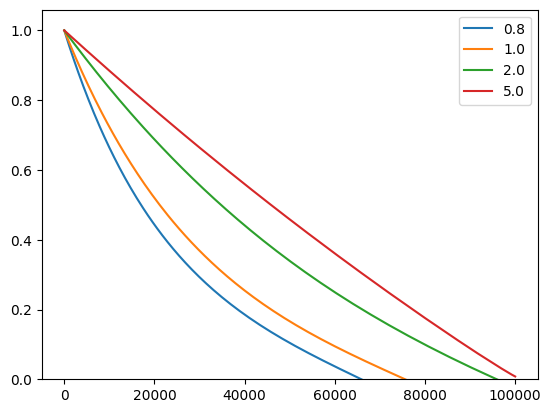

In [8]:
for key, Q in q_val_dict.items():
    plt.plot(Q, label=key/10)
    # plt.plot(np.linspace(0,1, len(Q[Q>0])),Q[Q>0], label=key/10)

plt.ylim(0, None)
plt.legend()
plt.show()